Subset downloaded successfully.


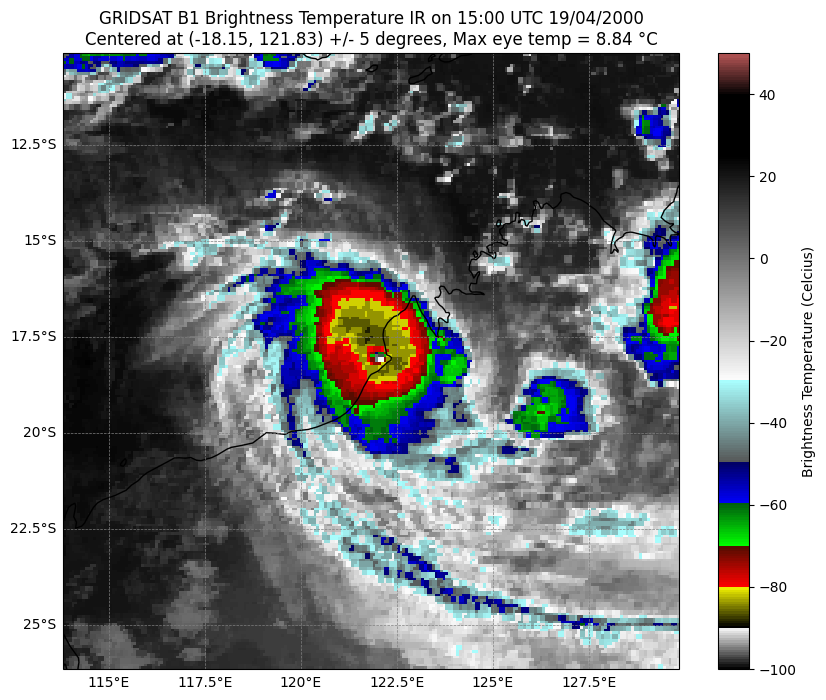

In [6]:
import subprocess, sys, datetime, requests
packages = ["netCDF4", "cartopy"]
for package in packages:
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])

import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import requests
import os
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def rammb():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/150, "#b55555"),
    (10/150, "#000000"),
    (25/150, "#000000"),
    (80/150, "#fefefe"),
    (80/150, "#a8fdfd"),
    (100/150, "#545454"),
    (100/150, "#000067"),
    (110/150, "#0000fe"),
    (110/150, "#00600d"),
    (120/150, "#00fc00"),
    (120/150, "#4d0d00"),
    (130/150, "#fb0000"),
    (130/150, "#fcfc00"),
    (140/150, "#000000"),
    (140/150, "#FFFFFF"),
    (150/150, "#040404")])

    vmax = 50
    vmin = -100

    return newcmp.reversed(), vmax, vmin

def bd():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/120, "#a8d1ff"),
    (11/120, "#000000"),
    (12/120, "#000000"),
    (12/120, "#1d1d1d"),
    (21/120, "#fafafa"),
    (21/120, "#3a3a3a"),
    (60/120, "#d2d2d2"),
    (60/120, "#5b5b5b"),
    (71/120, "#5b5b5b"),
    (71/120, "#9a9a9a"),
    (83/120, "#9a9a9a"),
    (83/120, "#b7b7b7"),
    (93/120, "#b7b7b7"),
    (93/120, "#000000"),
    (99/120, "#000000"),
    (99/120, "#f9f9f9"),
    (105/120, "#f9f9f9"),
    (105/120, "#9e9e9e"),
    (110/120, "#9e9e9e"),
    (110/120, "#424242"),
    (120/120, "#424242")])

    vmax = 30
    vmin = -90

    return newcmp.reversed(), vmax, vmin

def download_subset_nc(year, month, day, hour, lat_min, lat_max, lon_min, lon_max):
    base_url = "https://www.ncei.noaa.gov/thredds/ncss/cdr/gridsat"
    filename = f"GRIDSAT-B1.{year}.{str(month).zfill(2)}.{str(day).zfill(2)}.{str(hour).zfill(2)}.v02r01.nc"
    subset_url = f"{base_url}/{year}/{filename}?var=irwin_cdr&north={lat_max}&south={lat_min}&east={lon_max}&west={lon_min}&accept=netcdf"

    response = requests.get(subset_url)
    if response.status_code == 200:
        with open("gridsatfile.nc", "wb") as f:
            f.write(response.content)
        print("Subset downloaded successfully.")
    else:
        print(f"Failed to download subset. Status code: {response.status_code}")

year = 2000
month = 4
day = 19
hour = 15

center_lat = -18.15	 	 	 # Center latitude
center_lon = 121.83   # Center longitude
extent = 8  # Extent in degrees
colormap = 'rammb' #colormap

destination = 'gridsatfile.nc'

# Calculate the bounds
lat_min, lat_max = center_lat - extent, center_lat + extent
lon_min, lon_max = center_lon - extent, center_lon + extent

download_subset_nc(year, month, day, hour, lat_min, lat_max, lon_min, lon_max)

# Load the NetCDF file147.36
dataset = xr.open_dataset(destination, decode_times=False)


lat = dataset['lat']
lon = dataset['lon']
brightness_temp = dataset['irwin_cdr']


brightness_temp_slice = brightness_temp.isel(time=0)


# Select data within the specified bounds
selected_lat = lat[(lat >= lat_min) & (lat <= lat_max)]
selected_lon = lon[(lon >= lon_min) & (lon <= lon_max)]
selected_brightness_temp = brightness_temp_slice.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

# Select eye temperature data within the specified bounds
selected_eye_temp = brightness_temp_slice.sel(lat=slice(center_lat-1, center_lat+1), lon=slice(center_lon-1, center_lon+1))

selected_brightness_temp = brightness_temp_slice.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

def kelvin_to_celsius(kelvin_temp):
    celsius_temp = np.array(kelvin_temp) - 273.15
    return celsius_temp

selected_brightness_temp = kelvin_to_celsius(selected_brightness_temp.values)

# Find the maximum temperature
max_temp = "{:.2f}".format(np.max(selected_eye_temp.values))

def kelvin_to_celsius(kelvin_temp):
    celsius_temp = float(kelvin_temp) - 273.15
    return "{:.2f}".format(celsius_temp)

projection = ccrs.PlateCarree()

plt.figure(figsize=(10, 8))
ax = plt.axes(projection=projection)
rambIR, vmax, vmin = rammb()
bdIR, vm, vn = bd()
col = ""
if colormap == 'bd':
  col = bdIR
  maxv = 30
  minv = -90
elif colormap == 'rammb':
  col = rambIR
  maxv = 50
  minv = -100
else:
  col = "CMRmap"
  maxv = 30
  minv = -90

pcolor = ax.pcolormesh(selected_lon, selected_lat, selected_brightness_temp, cmap=col, transform=projection, vmax=maxv, vmin=minv)
ax.coastlines()
ax.set_xlabel('Longitude (degrees_east)')
ax.set_ylabel('Latitude (degrees_north)')
ax.set_title(f'GRIDSAT B1 Brightness Temperature IR on {str(hour).zfill(2)}:00 UTC {str(day).zfill(2)}/{str(month).zfill(2)}/{year}\nCentered at ({center_lat}, {center_lon}) +/- 5 degrees, Max eye temp = {kelvin_to_celsius(max_temp)} °C')
gls = ax.gridlines(draw_labels=True, linewidth=0.5, linestyle='--', color='gray')
gls.top_labels = False
gls.right_labels = False
cbar = plt.colorbar(pcolor, label='Brightness Temperature (Celcius)')
plt.show()

dataset.close()
#os.remove(destination)